In [76]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime as dt
import statsmodels.api as sm
import requests
import json
from functools import reduce
import warnings

warnings.filterwarnings('ignore')

In [77]:
# IBC-Br (Mensal) (Índice) (Com ajuste sazonal)
ibc = pd.read_json('https://api.bcb.gov.br/dados/serie/bcdata.sgs.24364/dados?formato=json')
ibc.rename(columns = {'valor' : 'ibc'}, inplace = True)

# PIB Trimestral Dessazonalizado
pib = pd.read_json('https://api.bcb.gov.br/dados/serie/bcdata.sgs.22109/dados?formato=json')
pib.rename(columns = {'valor' : 'pib'}, inplace = True)

In [78]:
ibc['data'] = pd.to_datetime(ibc['data'], format = "%d/%m/%Y") #Transformando em datetime
ibc = ibc.groupby(ibc['data'].dt.to_period("Q"))['ibc'].mean().to_frame() #Agrupando o IBC por média trimestral
ibc['ibc_var'] = ((ibc['ibc'] / ibc['ibc'].shift(1)) - 1 ) * 100 #Calculando a variação trimestral
ibc.reset_index(inplace = True) 

pib['data'] = pd.to_datetime(pib['data'], format = "%d/%m/%Y") #Transformando em datetime
pib = pib[pib['data'].dt.year >= 2003] #Selecionando o período equivalente ao IBC
pib['data'] = pib['data'].dt.to_period("Q") #Colocando a coluna de data em Quarters
pib['pib_var'] = ((pib['pib'] / pib['pib'].shift(1)) - 1 ) * 100 #Calculando variação trimestral

df = ibc.merge(pib, left_on = 'data', right_on = 'data', how = 'left') #Merge dos dois datasets
df.dropna(inplace = True)
df.reset_index(inplace = True)

In [79]:
#Modelo Linear para previsão do PIB Trimestral à Preços Correntes
y = df['pib_var']
x = df['ibc_var']
x = sm.add_constant(x)

model = sm.OLS(y,x)
results = model.fit()

ibc['safra'] = pd.to_datetime((ibc['data'].dt.year).astype(str) + "-" + (ibc['data'].dt.month).astype(str) + "-01") #Coluna que servirá como data para série temporal
pib['safra'] = pd.to_datetime((pib['data'].dt.year).astype(str) + "-" + (pib['data'].dt.month).astype(str) + "-01") #Coluna que servirá como data para série temporal
ult_tri_ibc = ibc[ibc['safra'] == ibc['safra'].max()]['ibc_var'] #Variação do IBC do último trimestre registrado
ult_tri_pib = pib[pib['safra'] == pib['safra'].max()]['pib'] #valor do PIB do último trimestre registrado

cons = results.params[0] #Constante
coef = results.params[1] #Coeficiente

#Intervalos de confiança do coeficiente
int_conf_menor = results.conf_int().iloc[1,0]
int_conf_maior = results.conf_int().iloc[1,1]

#Previsão do Trimestre Q3 do PIB (que ainda não está disponível) com dados do IBC-Br que já estão disponíveis.
previsao_var_pib = cons + coef * ult_tri_ibc
previsao_pib = ult_tri_pib.values * ((previsao_var_pib / 100) + 1) 

print("Previsão Variação PIB Trimestral (%): ", previsao_var_pib)
print("Previsão PIB Trimestral: ", previsao_pib)
print("A cada 1% de variação trimestral no IBC-Br Dessazonalizado, verificamos uma variação média\n no PIB Trimestral à Preços de Mercado de ",coef.round(3)," num intervalo de variação entre ",int_conf_menor.round(3), " e ",int_conf_maior.round(3))


Previsão Variação PIB Trimestral (%):  82   -0.164274
Name: ibc_var, dtype: float64
Previsão PIB Trimestral:  82    184.15698
Name: ibc_var, dtype: float64
A cada 1% de variação trimestral no IBC-Br Dessazonalizado, verificamos uma variação média
 no PIB Trimestral à Preços de Mercado de  0.796  num intervalo de variação entre  0.743  e  0.848


In [80]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                pib_var   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     914.9
Date:                Sun, 22 Oct 2023   Prob (F-statistic):           3.39e-45
Time:                        18:34:24   Log-Likelihood:                -58.121
No. Observations:                  81   AIC:                             120.2
Df Residuals:                      79   BIC:                             125.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1848      0.057      3.228      0.0

In [81]:
df['var_prev'] = pd.DataFrame(results.predict())
df['safra'] = pd.to_datetime((df['data'].dt.year).astype(str) + "-" + (df['data'].dt.month).astype(str) + "-01")
df['pib_prev'] = df['pib'].shift(1) * ((df['var_prev'] / 100) + 1)

In [82]:
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(df['pib_var'], df['var_prev'], squared=True)
rms

0.2459080236391916

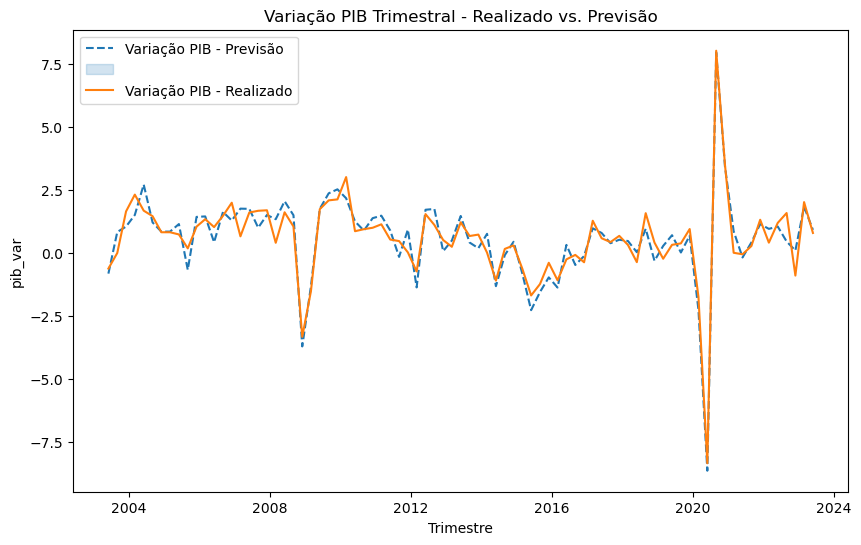

In [83]:
axes = plt.subplots(figsize = (10,6))

ax1 = sns.lineplot(data = df, x = 'safra', y = 'pib_var')
ax1 = sns.lineplot(data = df, x = 'safra', y = 'var_prev')

ax1.lines[0].set_linestyle("--")
plt.legend(['Variação PIB - Previsão', '', 'Variação PIB - Realizado'])
info = ax1.set(title = "Variação PIB Trimestral - Realizado vs. Previsão", xlabel = "Trimestre")

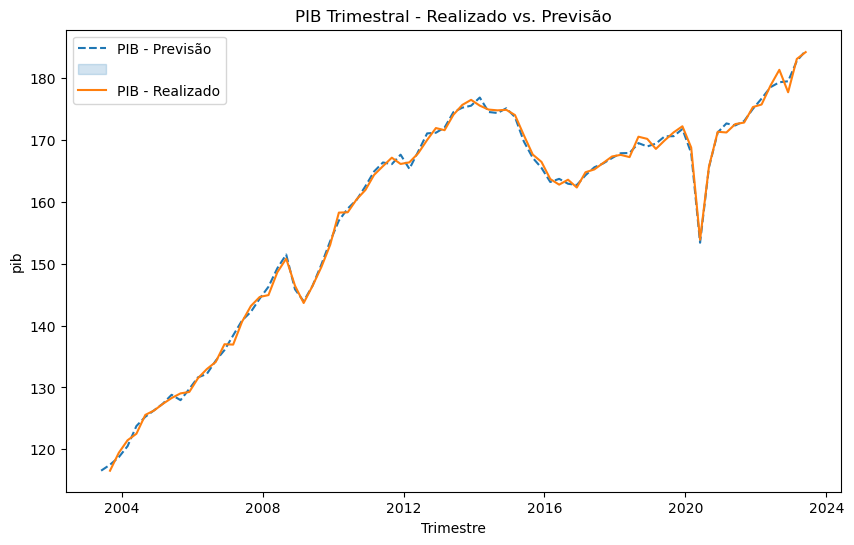

In [84]:
axes = plt.subplots(figsize = (10,6))

ax2 = sns.lineplot(data = df, x = 'safra', y = 'pib')
ax2 = sns.lineplot(data = df, x = 'safra', y = 'pib_prev')

ax2.lines[0].set_linestyle("--")
plt.legend(['PIB - Previsão', '', 'PIB - Realizado'])
info = ax2.set(title = "PIB Trimestral - Realizado vs. Previsão", xlabel = "Trimestre")